# Description

It analyzes how correlation coefficients intersect on different gene pairs. Basically, I take the top gene pairs with the maximum correlation coefficient according to Pearson, Spearman and Clustermatch, and also the equivalent set with the minimum coefficient values, and then compare how these sets intersect each other.

After identifying different intersection sets, I plot some gene pairs to see what's being captured or not by each coefficient.

# Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import plot, from_indicators

from clustermatch.plots import MyUpSet
from clustermatch import conf

# Settings

In [2]:
DATASET_CONFIG = conf.RECOUNT2
# GTEX_TISSUE = "whole_blood"
# GENE_SEL_STRATEGY = "var_pc_log2"

In [3]:
# this specificies the threshold to compare coefficients (see below).
# it basically takes the top Q_DIFF coefficient values for gene pairs
# and compare with the bottom Q_DIFF of the other coefficients
Q_DIFF = 0.30

# Paths

In [4]:
assert (
    conf.MANUSCRIPT["BASE_DIR"] is not None and conf.MANUSCRIPT["BASE_DIR"].exists()
), "Manuscript dir not set"

In [5]:
OUTPUT_FIGURE_DIR = conf.MANUSCRIPT["FIGURES_DIR"] / "coefs_comp" / f"recount2"
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp/recount2')

In [6]:
INPUT_GENE_EXPR_FILE = conf.RECOUNT2["DATA_FILE"]
display(INPUT_GENE_EXPR_FILE)

assert INPUT_GENE_EXPR_FILE.exists()

PosixPath('/opt/data/data/recount2/recount_data_prep_PLIER.pkl')

In [7]:
INPUT_CORR_FILE_TEMPLATE = (
    DATASET_CONFIG["SIMILARITY_MATRICES_DIR"]
    / DATASET_CONFIG["SIMILARITY_MATRIX_FILENAME_TEMPLATE"]
)
display(INPUT_CORR_FILE_TEMPLATE)

PosixPath('/opt/data/results/recount2/similarity_matrices/recount_data_prep_PLIER-{corr_method}.pkl')

In [8]:
INPUT_CORR_FILE = DATASET_CONFIG["SIMILARITY_MATRICES_DIR"] / str(
    INPUT_CORR_FILE_TEMPLATE
).format(
    corr_method="all",
)
display(INPUT_CORR_FILE)

assert INPUT_CORR_FILE.exists()

PosixPath('/opt/data/results/recount2/similarity_matrices/recount_data_prep_PLIER-all.pkl')

# Data

## Gene Ensembl ID -> Symbol mapping

In [9]:
# gene_map = pd.read_pickle(
#     DATASET_CONFIG["DATA_DIR"] / "gtex_gene_id_symbol_mappings.pkl"
# )

In [10]:
# gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [11]:
# assert gene_map["ENSG00000145309.5"] == "CABS1"

## Gene expression

In [12]:
gene_expr_df = pd.read_pickle(INPUT_GENE_EXPR_FILE)

In [13]:
gene_expr_df.shape

(6750, 37032)

In [14]:
gene_expr_df.head()

,SRP000599.SRR013549,SRP000599.SRR013550,SRP000599.SRR013551,SRP000599.SRR013552,SRP000599.SRR013553,SRP000599.SRR013554,SRP000599.SRR013555,SRP000599.SRR013556,SRP000599.SRR013557,SRP000599.SRR013558,...,SRP035599.SRR1139372,SRP035599.SRR1139393,SRP035599.SRR1139388,SRP035599.SRR1139378,SRP035599.SRR1139399,SRP035599.SRR1139386,SRP035599.SRR1139375,SRP035599.SRR1139382,SRP035599.SRR1139356,SRP035599.SRR1139370
GAS6,-0.312500,-0.312931,-0.312931,-0.312931,-0.312931,-0.308253,-0.312931,-0.312931,-0.312931,-0.312931,...,-0.301711,-0.305581,-0.303344,-0.297800,-0.307122,-0.285499,-0.309599,-0.300220,-0.297667,-0.310151
MMP14,-0.328279,-0.328279,-0.328279,-0.328279,-0.328279,-0.328279,-0.328279,-0.328279,-0.328279,-0.325140,...,-0.314587,-0.322952,-0.326439,-0.325994,-0.326272,-0.322523,-0.326375,-0.326339,-0.322127,-0.327438
DSP,-0.286319,-0.286859,-0.286859,-0.286859,-0.286859,-0.286859,-0.277195,-0.256862,-0.278790,-0.269701,...,-0.286859,-0.286859,-0.286745,-0.286688,-0.286725,-0.286529,-0.286859,-0.286671,-0.286859,-0.286740
MARCKSL1,-0.536646,-0.536646,-0.536646,-0.536646,-0.536646,-0.536646,-0.536646,-0.536646,-0.536646,-0.536646,...,0.807663,1.294564,1.527655,1.404788,1.047931,0.892119,1.507099,2.458255,2.919662,1.410846
SPARC,-0.370498,-0.370498,-0.369171,-0.370498,-0.370498,-0.370498,-0.370498,-0.370498,-0.370498,-0.370498,...,-0.345409,-0.310750,-0.348120,-0.356938,-0.355206,-0.366197,-0.351174,-0.363703,-0.350825,-0.360762


## Correlation

In [15]:
df = pd.read_pickle(INPUT_CORR_FILE)

In [16]:
df.shape

(22777875, 3)

In [17]:
df.head()

clustermatch   pearson  spearman
A2M AATK         0.134712  0.032274  0.504520
    ABCA1        0.109580  0.110068  0.443315
    ABCA6        0.189934  0.050592  0.536541
    ABCC3        0.088957  0.053941  0.373502
    ABHD14A      0.082554  0.012871  0.367407

In [18]:
# show quantiles
df.apply(lambda x: x.quantile(np.linspace(0.20, 1.0, 20)))

,clustermatch,pearson,spearman
0.200000,0.078577,0.006544,0.230251
0.242105,0.084843,0.008229,0.253442
0.284211,0.090594,0.010058,0.274246
0.326316,0.095994,0.012050,0.293359
0.368421,0.101155,0.014226,0.311251
0.410526,0.106158,0.016620,0.328227
0.452632,0.111067,0.019261,0.344578
0.494737,0.115950,0.022200,0.360455
0.536842,0.120871,0.025494,0.376053
0.578947,0.125909,0.029216,0.391581


# Prepare data for plotting

In [19]:
def get_lower_upper_quantile(method_name, q):
    return df[method_name].quantile([q, 1 - q])

In [20]:
# test
_tmp = get_lower_upper_quantile("clustermatch", 0.20)
display(_tmp)

_tmp0, _tmp1 = _tmp
display((_tmp0, _tmp1))

assert _tmp0 == _tmp.iloc[0]
assert _tmp1 == _tmp.iloc[1]

0.2    0.078577
0.8    0.159555
Name: clustermatch, dtype: float64

(0.07857705540812895, 0.15955487431587542)

In [21]:
clustermatch_lq, clustermatch_hq = get_lower_upper_quantile("clustermatch", Q_DIFF)
display((clustermatch_lq, clustermatch_hq))

pearson_lq, pearson_hq = get_lower_upper_quantile("pearson", Q_DIFF)
display((pearson_lq, pearson_hq))

spearman_lq, spearman_hq = get_lower_upper_quantile("spearman", Q_DIFF)
display((spearman_lq, spearman_hq))

(0.0926551971986533, 0.14200537737083768)

(0.010782481893314655, 0.043447854524251414)

(0.28159307476882095, 0.4374603040308761)

In [22]:
pearson_higher = df["pearson"] >= pearson_hq
display(pearson_higher.sum())

pearson_lower = df["pearson"] <= pearson_lq
display(pearson_lower.sum())

6833363

6833363

In [23]:
spearman_higher = df["spearman"] >= spearman_hq
display(spearman_higher.sum())

spearman_lower = df["spearman"] <= spearman_lq
display(spearman_lower.sum())

6833363

6833363

In [24]:
clustermatch_higher = df["clustermatch"] >= clustermatch_hq
display(clustermatch_higher.sum())

clustermatch_lower = df["clustermatch"] <= clustermatch_lq
display(clustermatch_lower.sum())

6833363

6833363

# UpSet plot

In [25]:
df_plot = pd.DataFrame(
    {
        "pearson_higher": pearson_higher,
        "pearson_lower": pearson_lower,
        "spearman_higher": spearman_higher,
        "spearman_lower": spearman_lower,
        "clustermatch_higher": clustermatch_higher,
        "clustermatch_lower": clustermatch_lower,
    }
)

In [26]:
df_plot = pd.concat([df_plot, df], axis=1)

In [27]:
df_plot

pearson_higher  pearson_lower  spearman_higher  spearman_lower  \
A2M AATK              False          False             True           False   
    ABCA1              True          False             True           False   
    ABCA6              True          False             True           False   
    ABCC3              True          False            False           False   
    ABHD14A           False          False            False           False   
...                     ...            ...              ...             ...   
ZYX ZNF703            False          False             True           False   
    ZNF708             True          False            False            True   
    ZNF92              True          False            False            True   
    ZNFX1              True          False             True           False   
    ZW10              False          False            False           False   

             clustermatch_higher  clustermatch_lower  clustermatch   pearson  \
A2M AATK                   False               False      0.134712  0.032274   
    ABCA1                  False               False      0.109580  0.110068   
    ABCA6                   True               False      0.189934  0.050592   
    ABCC3                  False                True      0.088957  0.053941   
    ABHD14A                False                True      0.082554  0.012871   
...                          ...                 ...           ...       ...   
ZYX ZNF703                  True               False      0.159615  0.035755   
    ZNF708                 False                True      0.084440  0.046003   
    ZNF92                  False               False      0.097004  0.066255   
    ZNFX1                  False               False      0.131054  0.148579   
    ZW10                   False               False      0.121611  0.023487   

             spearman  
A2M AATK     0.504520  
    ABCA1    0.443315  
    ABCA6    0.536541  
    ABCC3    0.373502  
    ABHD14A  0.367407  
...               ...  
ZYX ZNF703   0.497143  
    ZNF708   0.209802  
    ZNF92    0.212738  
    ZNFX1    0.512701  
    ZW10     0.328598  

[22777875 rows x 9 columns]

In [28]:
assert not df_plot.isna().any().any()

In [29]:
df_plot = df_plot.rename(
    columns={
        "pearson_higher": "Pearson (high)",
        "pearson_lower": "Pearson (low)",
        "spearman_higher": "Spearman (high)",
        "spearman_lower": "Spearman (low)",
        "clustermatch_higher": "Clustermatch (high)",
        "clustermatch_lower": "Clustermatch (low)",
    }
)

In [30]:
categories = sorted(
    [x for x in df_plot.columns if " (" in x],
    reverse=True,
    key=lambda x: x.split(" (")[1] + " (" + x.split(" (")[0],
)

In [31]:
categories

['Spearman (low)',
 'Pearson (low)',
 'Clustermatch (low)',
 'Spearman (high)',
 'Pearson (high)',
 'Clustermatch (high)']

## All subsets (original full plot)

In [32]:
df_r_data = df_plot

In [33]:
df_r_data.shape

(22777875, 9)

In [34]:
gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [35]:
gene_pairs_by_cats

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            False          False                         False   
                                                                True           False                          True   
                                                                               True                           True   
                             True               False           True           False                          True   
                                                                False          False                         False   
...                                                                                                            ...   
                             False              True            False          True                          False   
True           False         True               False           True           False                          True   
                             False              False           True           False                          True   
False          False         False              True            True           False                          True   
                                                False           False          False                         False   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            False          False                        False   
                                                                True           False                        False   
                                                                               True                         False   
                             True               False           True           False                        False   
                                                                False          False                        False   
...                                                                                                           ...   
                             False              True            False          True                         False   
True           False         True               False           True           False                        False   
                             False              False           True           False                        False   
False          False         False              True            True           False                        False   
                                                False           False          False                        False   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            False          False                           True   
                                                                True           False                           True   
                                                                               True                            True   
                             True               False           True           False                          False   
                                                                False          False                          False   
...                                                                                                             ...   
                             False              True            False          True        

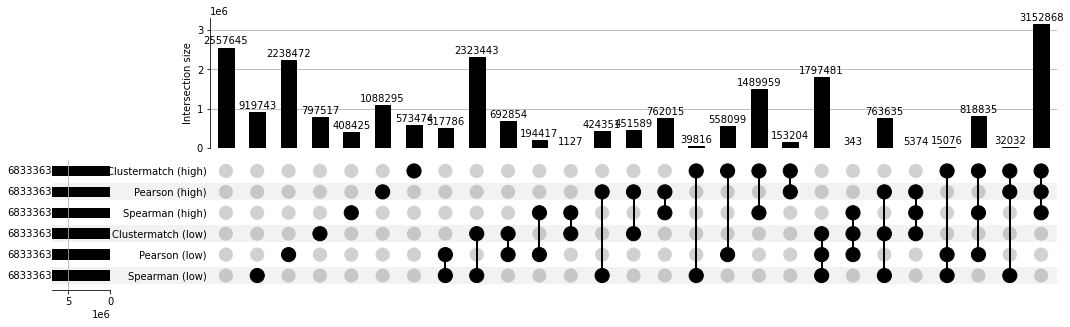

In [36]:
fig = plt.figure(figsize=(18, 5))

g = plot(
    gene_pairs_by_cats,
    show_counts=True,
    sort_categories_by=None,
    element_size=None,
    fig=fig,
)

## Remove subsets of size one

I leave this part commented out just in case it is useful in the future.

In [37]:
# # remove cases that are found only in one group
# df_r_data = df_plot[df_plot[categories].sum(axis=1) > 1]
# display(df_r_data.shape)

In [38]:
# df_r_data.shape

In [39]:
# gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [40]:
# fig = plt.figure(figsize=(15, 5))

# g = plot(
#     gene_pairs_by_cats,
#     show_counts=True,
#     sort_categories_by=None,
#     element_size=None,
#     fig=fig,
# )

# g["totals"].set_visible(False)

## Remove non-interesting subsets

I leave this part commented out just in case it is useful in the future.

In [41]:
# lower_columns = [x for x in categories if x.endswith("_lower")]
# display(lower_columns)

# higher_columns = [x for x in categories if x.endswith("_higher")]
# display(higher_columns)

In [42]:
# df_r_data = df_plot[
#     (df_plot[categories].sum(axis=1) > 1)
#     & ~(
#         (df_plot[lower_columns].sum(axis=1).isin((0, 3)))
#         & (df_plot[higher_columns].sum(axis=1).isin((0, 3)))
#     )
# ]

In [43]:
# df_r_data.shape

In [44]:
# gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [45]:
# fig = plt.figure(figsize=(17, 5))

# g = plot(
#     gene_pairs_by_cats,
#     show_counts=True,
#     sort_categories_by=None,
#     element_size=None,
#     fig=fig,
# )

# g["totals"].set_visible(False)

## Sort by categories of subsets

In [46]:
df_r_data = df_plot

In [47]:
df_r_data.shape

(22777875, 9)

In [48]:
gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [49]:
gene_pairs_by_cats

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            False          False                         False   
                                                                True           False                          True   
                                                                               True                           True   
                             True               False           True           False                          True   
                                                                False          False                         False   
...                                                                                                            ...   
                             False              True            False          True                          False   
True           False         True               False           True           False                          True   
                             False              False           True           False                          True   
False          False         False              True            True           False                          True   
                                                False           False          False                         False   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            False          False                        False   
                                                                True           False                        False   
                                                                               True                         False   
                             True               False           True           False                        False   
                                                                False          False                        False   
...                                                                                                           ...   
                             False              True            False          True                         False   
True           False         True               False           True           False                        False   
                             False              False           True           False                        False   
False          False         False              True            True           False                        False   
                                                False           False          False                        False   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            False          False                           True   
                                                                True           False                           True   
                                                                               True                            True   
                             True               False           True           False                          False   
                                                                False          False                          False   
...                                                                                                             ...   
                             False              True            False          True        

In [50]:
gene_pairs_by_cats = gene_pairs_by_cats.sort_index()

In [51]:
_tmp_index = gene_pairs_by_cats.index.unique().to_frame(False)
display(_tmp_index)

,Spearman (low),Pearson (low),Clustermatch (low),Spearman (high),Pearson (high),Clustermatch (high)
0,False,False,False,False,False,False
1,False,False,False,False,False,True
2,False,False,False,False,True,False
3,False,False,False,False,True,True
4,False,False,False,True,False,False
5,False,False,False,True,False,True
6,False,False,False,True,True,False
7,False,False,False,True,True,True
8,False,False,True,False,False,False
9,False,False,True,False,True,False


In [52]:
_tmp_index[_tmp_index.sum(axis=1) == 3]

,Spearman (low),Pearson (low),Clustermatch (low),Spearman (high),Pearson (high),Clustermatch (high)
7,False,False,False,True,True,True
11,False,False,True,True,True,False
15,False,True,False,True,False,True
17,False,True,True,True,False,False
21,True,False,False,False,True,True
23,True,False,True,False,True,False
25,True,True,False,False,False,True
26,True,True,True,False,False,False


In [53]:
_tmp_index.apply(lambda x: x[0:3].sum() == 0, axis=1)

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
dtype: bool

In [54]:
# agreements on top
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[0:3].sum() == 0, axis=1)
        & _tmp_index.apply(lambda x: 3 > x[3:].sum() > 1, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, False, False, False, True, True),
       (False, False, False, True, False, True),
       (False, False, False, True, True, False)], dtype=object)

In [55]:
# agreements on bottom
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: 3 > x[0:3].sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[3:].sum() == 0, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, True, True, False, False, False),
       (True, False, True, False, False, False),
       (True, True, False, False, False, False)], dtype=object)

In [56]:
# diagreements
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[0:3].sum() > 0, axis=1)
        & _tmp_index.apply(lambda x: x[3:].sum() > 0, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, False, True, False, True, False),
       (False, False, True, True, False, False),
       (False, False, True, True, True, False),
       (False, True, False, False, False, True),
       (False, True, False, True, False, False),
       (False, True, False, True, False, True),
       (False, True, True, True, False, False),
       (True, False, False, False, False, True),
       (True, False, False, False, True, False),
       (True, False, False, False, True, True),
       (True, False, True, False, True, False),
       (True, True, False, False, False, True)], dtype=object)

In [57]:
# order subsets
gene_pairs_by_cats = gene_pairs_by_cats.loc[
    [
        # pairs not included in categories:
        # (False, False, False, False, False, False),
        # full agreements:
        (True, True, True, False, False, False),
        (False, False, False, True, True, True),
        # agreements on top
        (False, False, False, False, True, True),
        (False, False, False, True, False, True),
        (False, False, False, True, True, False),
        # agreements on bottom
        (False, True, True, False, False, False),
        (True, False, True, False, False, False),
        (True, True, False, False, False, False),
        # diagreements
        ## pearson
        (False, False, True, False, True, False),
        (True, False, False, False, True, False),
        (True, False, True, False, True, False),
        ## spearman
        (False, True, False, True, False, False),
        ## clustermatch
        (False, True, False, True, False, True),
        (False, True, False, False, False, True),
        (True, False, False, False, False, True),
        (True, True, False, False, False, True),
    ]
]

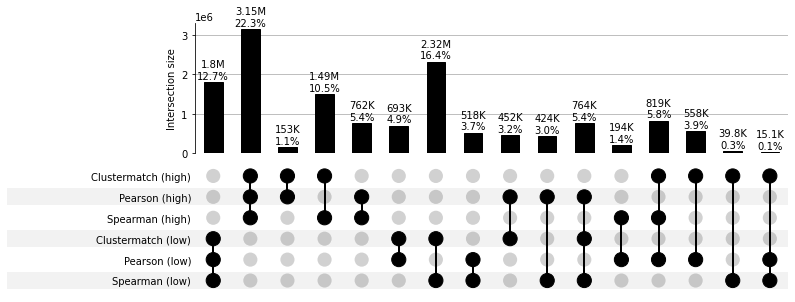

In [58]:
fig = plt.figure(figsize=(14, 5))

# g = plot(
g = MyUpSet(
    gene_pairs_by_cats,
    show_counts=True,
    sort_categories_by=None,
    sort_by=None,
    show_percentages=True,
    # min_subset_size=2,
    element_size=None,
    # fig=fig,
).plot(fig)

g["totals"].remove()  # set_visible(False)

# display(fig.get_size_inches())
# fig.set_size_inches(12, 5)

plt.savefig(
    OUTPUT_FIGURE_DIR / "upsetplot.svg",
    bbox_inches="tight",
    facecolor="white",
)

# plt.margins(x=-0.4)

This plot has the sets that represent agreements on the left, and disagreements on the right. The plot shown here is not the final one for the manuscript.

# Look at specific gene pair cases

In [60]:
def plot_gene_pair(top_pairs_df, idx, bins="log"):
    gene0, gene1 = top_pairs_df.iloc[idx].name
    display((gene0, gene1))

    # gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    # display((gene0_symbol, gene1_symbol))

    _pearson, _spearman, _clustermatch = top_pairs_df.loc[
        (gene0, gene1), ["pearson", "spearman", "clustermatch"]
    ].tolist()

    _title = f"Clustermatch: {_clustermatch:.2f}\nPearson/Spearman: {_pearson:.2f}/{_spearman:.2f}"

    # displot DOES SUPPORT HUE!
    p = sns.jointplot(
        data=gene_expr_df.T,
        x=gene0,
        y=gene1,
        kind="hex",
        bins=bins,
        # ylim=(0, 500),
    )

    gene_x_id = p.ax_joint.get_xlabel()
    # gene_x_symbol = gene_map[gene_x_id]
    p.ax_joint.set_xlabel(f"{gene_x_id}")

    gene_y_id = p.ax_joint.get_ylabel()
    # gene_y_symbol = gene_map[gene_y_id]
    p.ax_joint.set_ylabel(f"{gene_y_id}")

    p.fig.suptitle(_title)

    return p

In [62]:
# add columns with ranks
df_r_data = pd.concat(
    [
        df_r_data,
        df_r_data[["clustermatch", "pearson", "spearman"]]
        .rank()
        .rename(
            columns={
                "clustermatch": "clustermatch_rank",
                "pearson": "pearson_rank",
                "spearman": "spearman_rank",
            }
        ),
    ],
    axis=1,
)

In [63]:
df_r_data.head()

Pearson (high)  Pearson (low)  Spearman (high)  Spearman (low)  \
A2M AATK              False          False             True           False   
    ABCA1              True          False             True           False   
    ABCA6              True          False             True           False   
    ABCC3              True          False            False           False   
    ABHD14A           False          False            False           False   

             Clustermatch (high)  Clustermatch (low)  clustermatch   pearson  \
A2M AATK                   False               False      0.134712  0.032274   
    ABCA1                  False               False      0.109580  0.110068   
    ABCA6                   True               False      0.189934  0.050592   
    ABCC3                  False                True      0.088957  0.053941   
    ABHD14A                False                True      0.082554  0.012871   

             spearman  clustermatch_rank  pearson_rank  spearman_rank  
A2M AATK     0.504520         14766805.0    13890647.0     19285465.0  
    ABCA1    0.443315         10017767.5    20845501.0     16277878.0  
    ABCA6    0.536541         20542146.5    16942691.0     20444731.0  
    ABCC3    0.373502          6193954.0    17346769.0     12070919.0  
    ABHD14A  0.367407          5152684.0     7804954.0     11695106.0

## Clustermatch vs Spearman

In [64]:
first_coef = "clustermatch"
second_coef = "spearman"

In [65]:
_tmp_df = df_r_data[
    (df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & (df_r_data["Spearman (low)"])
    & ~(df_r_data["Pearson (low)"])
]

_tmp_df = _tmp_df.assign(
    rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_tmp_df[f"{second_coef}_rank"])
)

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df[[x for x in _tmp_df.columns if " (" not in x]].sort_values(
    "rank_diff", ascending=False
)

# sort by firt_coef value
# _tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
#     first_coef, ascending=False
# )

# display(_tmp_df.shape)
display(_tmp_df)

,,clustermatch,pearson,spearman,clustermatch_rank,pearson_rank,spearman_rank,rank_diff
SUV39H2,TOM1,0.216077,0.026209,0.098532,21526043.0,12422631.0,1116066.0,20409977.0
FANCM,TOM1,0.209351,0.020454,0.087552,21330542.0,10711846.0,953192.0,20377350.0
RAD54B,TOM1,0.192272,0.027336,0.057940,20657719.0,12719184.0,576075.0,20081644.0
DNA2,TOM1,0.203173,0.027326,0.093591,21119674.0,12716407.0,1040930.0,20078744.0
PPAT,TOM1,0.185846,0.015337,0.051317,20322700.0,8848333.0,501886.0,19820814.0
...,...,...,...,...,...,...,...,...
NDUFA4L2,ST20,0.142193,0.018747,0.281411,15972618.0,10131166.0,6824349.0,9148269.0
SCN2B,PGLYRP1,0.142188,0.029773,0.281583,15972006.0,13320653.0,6832886.0,9139120.0
CLN5,MRPL41,0.142076,0.017411,0.281253,15953973.0,9648613.0,6816349.0,9137624.0
PRPS2,ALOX12,0.142024,0.031513,0.281139,15946964.0,13721892.0,6810687.0,9136277.0


'Index: 0'

('SUV39H2', 'TOM1')

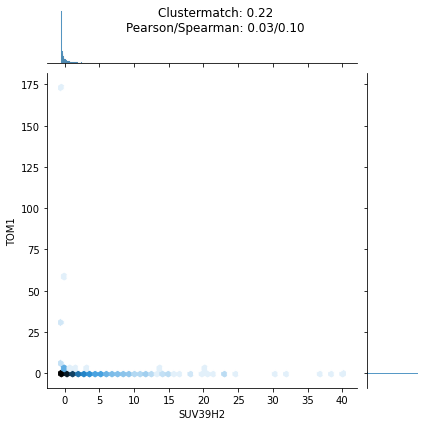

'Index: 1'

('FANCM', 'TOM1')

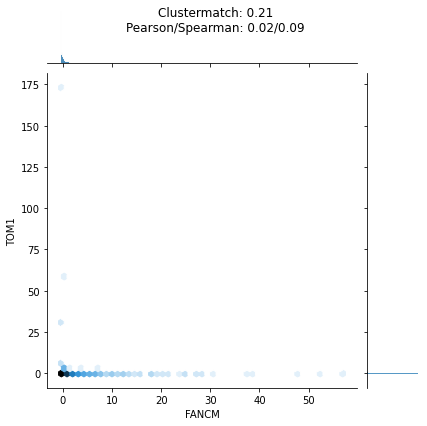

'Index: 2'

('RAD54B', 'TOM1')

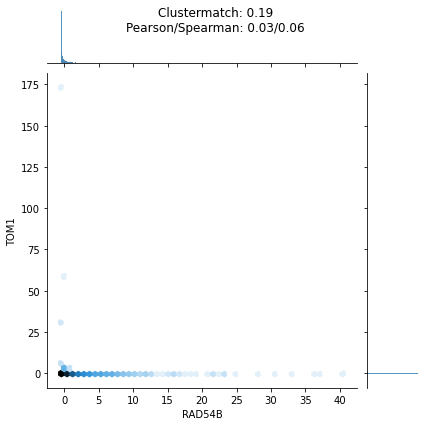

'Index: 3'

('DNA2', 'TOM1')

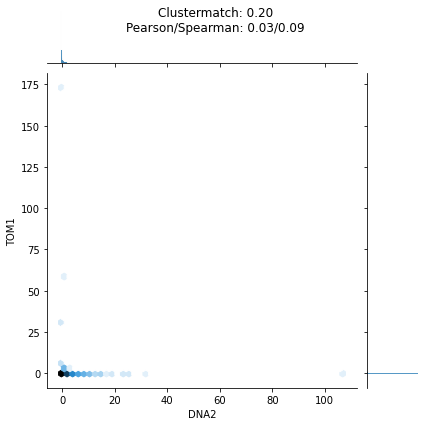

'Index: 4'

('PPAT', 'TOM1')

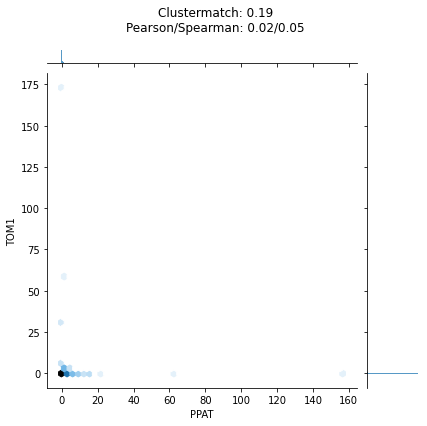

'Index: 5'

('WDHD1', 'TOM1')

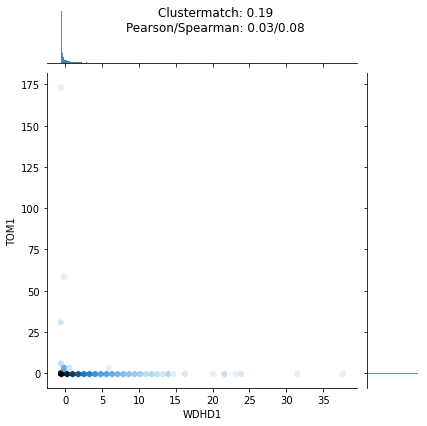

'Index: 6'

('ERCC6L', 'TOM1')

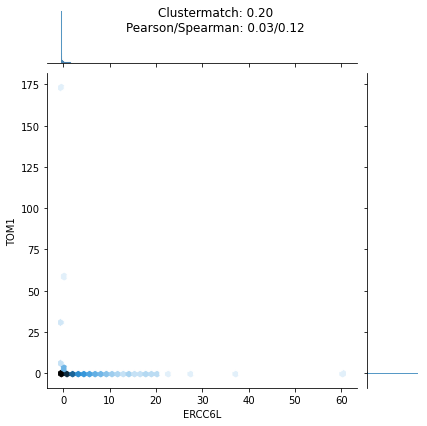

'Index: 7'

('TNFSF12', 'FANCB')

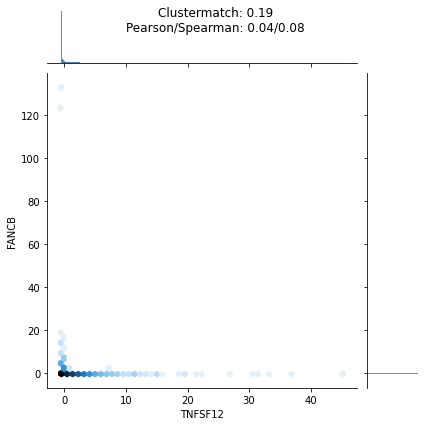

'Index: 8'

('NUP155', 'TOM1')

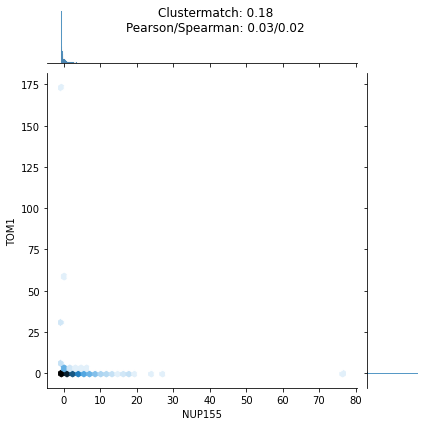

'Index: 9'

('POLA1', 'TOM1')

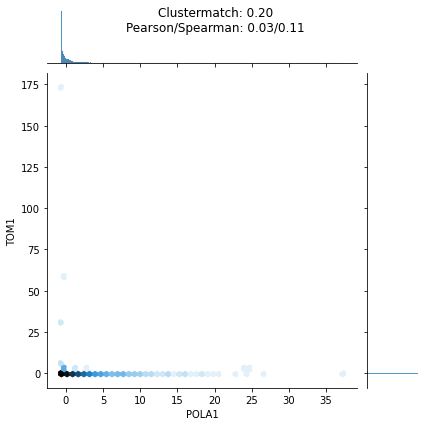

In [66]:
for i in range(10):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

'Index: 1'

('PIK3R4', 'MYH11')

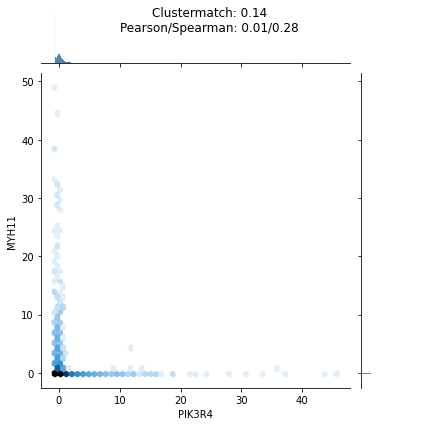

'Index: 2'

('PRPS2', 'ALOX12')

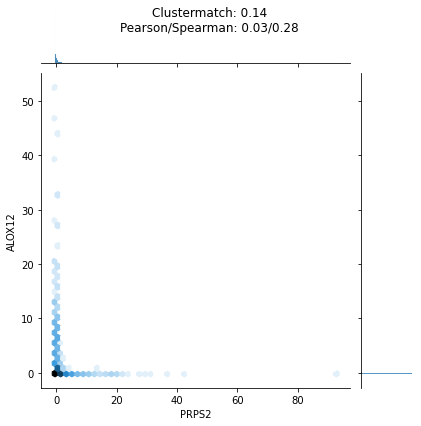

In [68]:
# reverse order
for i in range(1, 3):
    i = -i
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Clustermatch vs Pearson

In [ ]:
first_coef = "clustermatch"
second_coef = "pearson"

In [ ]:
_tmp_df = df_r_data[
    (df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & ~(df_r_data["Spearman (low)"])
    & (df_r_data["Pearson (low)"])
]

_tmp_df = _tmp_df.assign(
    rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_tmp_df[f"{second_coef}_rank"])
)

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df[[x for x in _tmp_df.columns if " (" not in x]].sort_values(
    "rank_diff", ascending=False
)

# sort by firt_coef value
# _tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
#     first_coef, ascending=False
# )

# display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
for i in range(10):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

In [ ]:
# reverse order
for i in range(1, 5):
    i = -i
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Clustermatch vs Spearman/Pearson

In [69]:
first_coef = "clustermatch"
second_coef = "pearson"
second_1_coef = "spearman"

In [70]:
_tmp_df = df_r_data[
    (df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & (df_r_data["Spearman (low)"])
    & (df_r_data["Pearson (low)"])
]

_tmp_df = _tmp_df.assign(
    rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_tmp_df[f"{second_coef}_rank"].add(_tmp_df[f"{second_1_coef}_rank"]))
)

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df[[x for x in _tmp_df.columns if " (" not in x]].sort_values(
    "rank_diff", ascending=False
)

# sort by firt_coef value
# _tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
#     first_coef, ascending=False
# )

# display(_tmp_df.shape)
display(_tmp_df)

,,clustermatch,pearson,spearman,clustermatch_rank,pearson_rank,spearman_rank,rank_diff
NUP35,IL11RA,0.180141,0.000951,0.150847,19974992.0,733555.0,2115784.0,17125653.0
CTSO,ALG8,0.164942,0.000377,0.143227,18768422.0,290071.0,1944102.0,16534249.0
ZNF394,PPP2CB,0.189388,0.000852,0.196159,20514763.0,657162.0,3353313.0,16504288.0
EXOSC3,PIK3IP1,0.155463,0.000849,0.062019,17760931.0,654626.0,623075.0,16483230.0
NOD2,NUDT11,0.180798,0.002171,0.145926,20016913.0,1656822.0,2003817.0,16356274.0
...,...,...,...,...,...,...,...,...
ZNF480,CCR10,0.143088,0.010490,0.280861,16106961.0,6689441.0,6796809.0,2620711.0
SMG5,KCNAB1,0.143697,0.010704,0.281243,16197213.0,6794865.0,6815835.0,2586513.0
GSS,CALCOCO1,0.142235,0.010457,0.279612,15978298.0,6672875.0,6735433.0,2569990.0
SIRT7,ZNF519,0.142407,0.010556,0.279399,16003983.0,6722265.0,6724825.0,2556893.0


'Index: 0'

('NUP35', 'IL11RA')

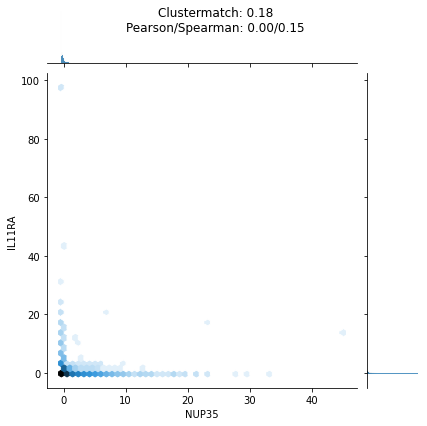

'Index: 1'

('CTSO', 'ALG8')

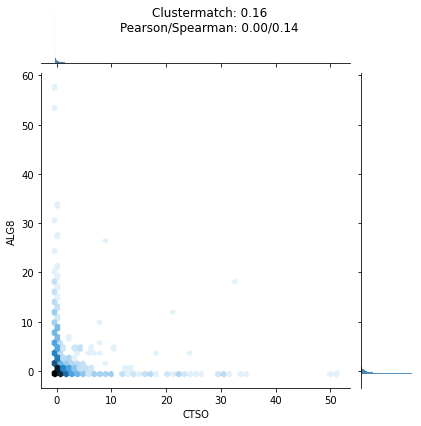

'Index: 2'

('ZNF394', 'PPP2CB')

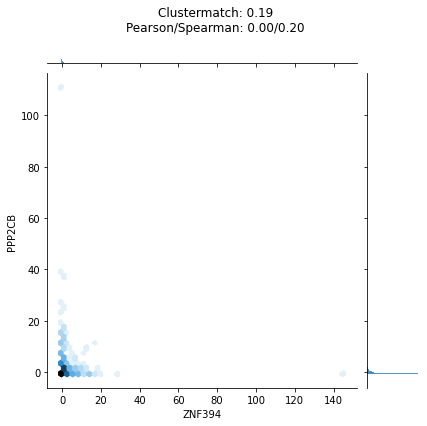

'Index: 3'

('EXOSC3', 'PIK3IP1')

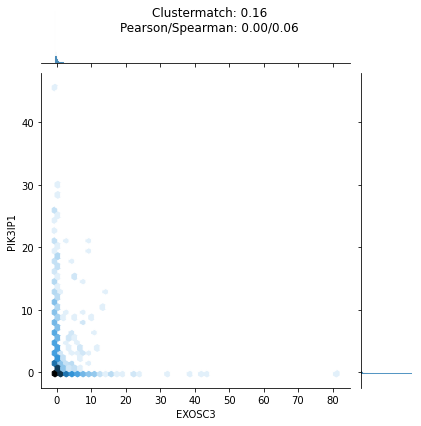

'Index: 4'

('NOD2', 'NUDT11')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f961e5deca0> (for post_execute):


KeyboardInterrupt: 

In [71]:
for i in range(5):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

In [1]:
# reverse order
for i in range(1, 5):
    i = -i
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

'Index: -1'

NameError: name 'plot_gene_pair' is not defined

In [ ]:
I NEED TO CHANGE THE CODE BELOW TO UPDATE IT WITH THE ONE ABOVE

## Clustermatch/Spearman vs Pearson

In [ ]:
_tmp_df = df_r_data[
    (df_r_data["clustermatch_higher"])
    & (df_r_data["spearman_higher"])
    & ~(df_r_data["pearson_higher"])
    & ~(df_r_data["clustermatch_lower"])
    & ~(df_r_data["spearman_lower"])
    & (df_r_data["pearson_lower"])
]

# show this just to make sure of the groups
# display(_tmp_df.head())

_tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
    "clustermatch", ascending=False
)

display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
plot_gene_pair(_tmp_df, 0)

In [ ]:
plot_gene_pair(_tmp_df, 1)

In [ ]:
plot_gene_pair(_tmp_df, 2)

## Pearson vs Spearman

In [ ]:
_tmp_df = df_r_data[
    ~(df_r_data["clustermatch_higher"])
    & ~(df_r_data["spearman_higher"])
    & (df_r_data["pearson_higher"])
    & ~(df_r_data["clustermatch_lower"])
    & (df_r_data["spearman_lower"])
    & ~(df_r_data["pearson_lower"])
]

# show this just to make sure of the groups
# display(_tmp_df.head())

_tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
    "pearson", ascending=False
)

display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
plot_gene_pair(_tmp_df, 0)

In [ ]:
plot_gene_pair(_tmp_df, 1)

In [ ]:
plot_gene_pair(_tmp_df, 2)

## Spearman vs Pearson

In [ ]:
_tmp_df = df_r_data[
    ~(df_r_data["clustermatch_higher"])
    & (df_r_data["spearman_higher"])
    & ~(df_r_data["pearson_higher"])
    & ~(df_r_data["clustermatch_lower"])
    & ~(df_r_data["spearman_lower"])
    & (df_r_data["pearson_lower"])
]

# show this just to make sure of the groups
# display(_tmp_df.head())

_tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
    "pearson", ascending=False
)

display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
plot_gene_pair(_tmp_df, 0)

In [ ]:
plot_gene_pair(_tmp_df, 1)

## Pearson vs Spearman/Clustermatch

In [ ]:
_tmp_df = df_r_data[
    ~(df_r_data["clustermatch_higher"])
    & ~(df_r_data["spearman_higher"])
    & (df_r_data["pearson_higher"])
    & (df_r_data["clustermatch_lower"])
    & (df_r_data["spearman_lower"])
    & ~(df_r_data["pearson_lower"])
]

# show this just to make sure of the groups
# display(_tmp_df.head())

_tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
    "pearson", ascending=False
)

display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
plot_gene_pair(_tmp_df, 0)

In [ ]:
plot_gene_pair(_tmp_df, 1)

## Pearson vs Clustermatch

In [ ]:
_tmp_df = df_r_data[
    ~(df_r_data["clustermatch_higher"])
    & ~(df_r_data["spearman_higher"])
    & (df_r_data["pearson_higher"])
    & (df_r_data["clustermatch_lower"])
    & ~(df_r_data["spearman_lower"])
    & ~(df_r_data["pearson_lower"])
]

# show this just to make sure of the groups
# display(_tmp_df.head())

_tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
    "pearson", ascending=False
)

display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
plot_gene_pair(_tmp_df, 0)

In [ ]:
gene0, gene1 = (
    gene_expr_df.loc["ENSG00000130598.15"].copy(),
    gene_expr_df.loc["ENSG00000177791.11"].copy(),
)

In [ ]:
cm(gene0, gene1)

In [ ]:
q = 0.75
gene0[gene0 <= gene0.quantile(q)] = 0
gene0[gene0 > gene0.quantile(q)] = 1

gene1[gene1 <= gene1.quantile(q)] = 0
gene1[gene1 > gene1.quantile(q)] = 1

cm(gene0, gene1)

In [ ]:
plot_gene_pair(_tmp_df, 500)

In [ ]:
gene0, gene1 = (
    gene_expr_df.loc["ENSG00000177409.11"].copy(),
    gene_expr_df.loc["ENSG00000149131.15"].copy(),
)

In [ ]:
cm(gene0, gene1)

In [ ]:
q = 0.75
gene0[gene0 <= gene0.quantile(q)] = 0
gene0[gene0 > gene0.quantile(q)] = 1

gene1[gene1 <= gene1.quantile(q)] = 0
gene1[gene1 > gene1.quantile(q)] = 1

cm(gene0, gene1)